In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

sns.set()

random_state = 123_456
np.random.seed(random_state)

In [32]:
non_categorical_features = ['price']
# non_categorical_features = ['price','price_t_plus_1']
# non_categorical_features = ['price','tapis_oil_price_t_minus_10','wholesale_price_t_minus_4',
#                             'sgd_exchange_rate_t_minus_6','price_t_plus_1']

In [33]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)
df = df[non_categorical_features]

In [34]:
df['price_t_minus_1'] = df.price.shift()
df.fillna(method='bfill', inplace=True)
df.price_t_minus_1 = df.price_t_minus_1.astype(np.int32)

df['price_t_minus_2'] = df.price.shift(2)
df.fillna(method='bfill', inplace=True)
df.price_t_minus_2 = df.price_t_minus_2.astype(np.int32)

df['price_3_day_ma'] = np.rint((df.price + df.price_t_minus_1 + df.price_t_minus_2) / 3).astype(np.int32)
del df['price_t_minus_1']
del df['price_t_minus_2']

df['price_t_plus_3'] = df.price.shift(-3)
df.fillna(method='ffill', inplace=True)
df.price_t_plus_3 = df.price_t_plus_3.astype(np.int32)
del df['price']

In [35]:
df

price_3_day_ma  price_t_plus_3
2017-01-01            1417            1542
2017-01-02            1423            1582
2017-01-03            1421            1529
2017-01-04            1462            1589
2017-01-05            1511            1567
...                    ...             ...
2019-12-27            1613            1602
2019-12-28            1601            1609
2019-12-29            1592            1609
2019-12-30            1590            1609
2019-12-31            1597            1609

[1095 rows x 2 columns]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Freq: D
Data columns (total 2 columns):
price_3_day_ma    1095 non-null int32
price_t_plus_3    1095 non-null int32
dtypes: int32(2)
memory usage: 17.1 KB


In [37]:
y = df.price_t_plus_3
del df['price_t_plus_3']
# y = df.price_t_plus_1
# del df['price_t_plus_1']

In [38]:
tscv = TimeSeriesSplit(n_splits=8, max_train_size=128)
tscv

TimeSeriesSplit(max_train_size=128, n_splits=8)

In [39]:
list_X_y = list()

for train_index, test_index in tscv.split(df):
    list_X_y.append(dict(X=df.iloc[train_index], y=y.iloc[train_index]))

In [40]:
y_hat_best = None
max_r2 = None

for X_y in list_X_y:
    est = linear_model.LinearRegression(normalize=False)
    est.fit(X_y['X'], X_y['y'])
    y_hat = np.rint(est.predict(df))
    this_r2 = r2_score(y, y_hat)
    print(round(this_r2,4))
    
    if not max_r2 or this_r2 > max_r2:
        max_r2 = this_r2
        y_hat_best = y_hat

0.6562
0.6175
0.6568
0.7206
0.567
0.75
0.7669
0.7048


In [41]:
%run get_relative_accuracy.ipynb

In [42]:
get_relative_accuracy(y.values, y_hat_best)

0.4520547945205479

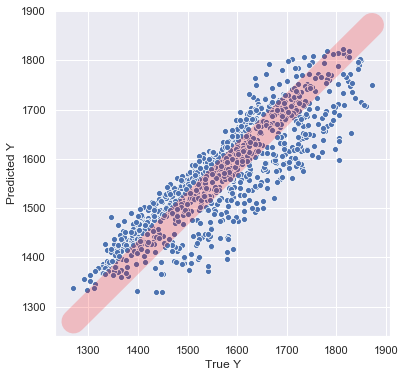

In [43]:
plot_score(y, y_hat_best)

In [44]:
# 57% using today's price
# 45% using 3day ma